# Clustering RNA sequences to identify cancer types

In this assignment, we will use clustering algorithms on RNA sequence data to identify cancer types.
Since the [whole data](https://www.synapse.org/#!Synapse:syn4301332) (from [Cancer Genome Atlas Pan-Cancer project](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3919969/)) is very big, we will use a [subset data from UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#). The subset data contains only 5 labels; BRCA, KIRC, COAD, LUAD and PRAD. The meanings of those labels are as below.

|Abbreviation|Cancer|
|:----:|:-------:|
|LUSC|Lung squamous cell carcinoma |
|READ |Rectum adenocarcinoma |
|GBM |Glioblastoma multiforme|
|BLCA |Bladder Urothelial Carcinoma|
|UCEC |Uterine Corpus Endometrioid Carcinoma|
|COAD |Colon adenocarcinoma|
|OV |Ovarian serous cystadenocarcinoma|
|LAML |Acute Myeloid Leukemia|
|HNSC |Head and Neck squamous cell carcinoma|
|LUAD |Lung adenocarcinoma|
|BRCA |Breast invasive carcinoma|
|KIRC |Kidney renal clear cell carcinoma|

Although we can use the data for supervised learning model training, we will not use these labels for training, but use them for evaluation.

In [1]:
%run data_loader.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import time

Data loaded


In [2]:
# Read data. Do not change the variable names (data, label)
data = pd.read_csv('data/data.csv')
label = pd.read_csv('data/labels.csv')
data=data.drop('Unnamed: 0',axis=1)
label=label.drop('Unnamed: 0',axis=1)

### A. Perform basic data inspection or EDA on the pandas dataframe.
<style>
    r {color: Red}
    b {color: rgb(55, 57, 196)}
</style>
- How many observations? <b>*801*</b>
- How many features? <b>*20531*</b>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5 MB


- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What do those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br>

Text(0.5, 1.0, 'Min histogram')

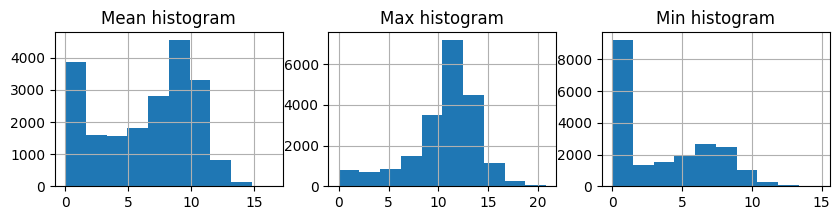

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(10,2)
data.mean().hist(ax=ax1)
data.max().hist(ax=ax2)
data.min().hist(ax=ax3)
ax1.set_title("Mean histogram")
ax2.set_title("Max histogram")
ax3.set_title("Min histogram")

<style>
    r {color: Red}
    b {color: rgb(55, 57, 196)}
</style>
- If we were to train a "supervised" learning model, how would you deal with such large feature dimension?  <b>I will select the most relevant features and train on them</b>
- Even after feature dimension reduction, still the number of useful features may be enormous. How it would impact performance or runtime of certain supervised learning algorithms? Which algorithms would suffer from high dimension features than others and why? 
- How it would impact performance or runtime of an unsupervised learning algorithm?
- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br> <br>

<Axes: >

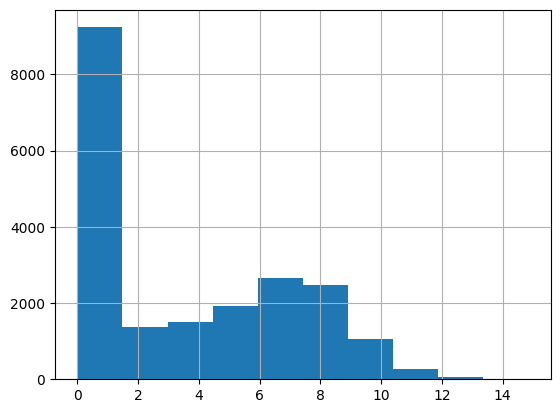